In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib

# Load and preprocess data
input_data = pd.read_csv('Datasets/datasewithtime.csv')
labels = pd.read_csv('Datasets/resp.csv')

features = ['Speed1', 'SteeringWheelAngle1', 'Speed2', 'SteeringWheelAngle2']
input_data = input_data[features]

# Handle missing values
input_data.fillna(method='ffill', inplace=True)
input_data.fillna(input_data.mean(), inplace=True)

target = labels['Driver1_Responsibility'].values / 100.0

# Create sequences
n_sequences = len(labels)
timesteps = 9
n_features = len(features)

input_data = input_data.iloc[:n_sequences * timesteps]
scaler = MinMaxScaler()
input_data_scaled = scaler.fit_transform(input_data)

X = []
for i in range(0, len(input_data_scaled), timesteps):
    sequence = input_data_scaled[i:i + timesteps]
    if len(sequence) == timesteps:
        X.append(sequence)
X = np.array(X)
Y = target[:len(X)]

# Save the scaler for later use
joblib.dump(scaler, 'scaler.pkl')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build and train model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(timesteps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2, verbose=1)

# Save the model
model.save('lstm_model.h5')

# Evaluate
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Epoch 1/50
4/4 [==============================] - 5s 269ms/step - loss: 0.0931 - mae: 0.2858 - val_loss: 0.1181 - val_mae: 0.3295
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 0.0881 - mae: 0.2759 - val_loss: 0.1197 - val_mae: 0.3321
Epoch 3/50
4/4 [==============================] - 0s 17ms/step - loss: 0.0862 - mae: 0.2717 - val_loss: 0.1211 - val_mae: 0.3342
Epoch 4/50
4/4 [==============================] - 0s 17ms/step - loss: 0.0851 - mae: 0.2686 - val_loss: 0.1244 - val_mae: 0.3386
Epoch 5/50
4/4 [==============================] - 0s 17ms/step - loss: 0.0855 - mae: 0.2668 - val_loss: 0.1274 - val_mae: 0.3424
Epoch 6/50
4/4 [==============================] - 0s 17ms/step - loss: 0.0856 - mae: 0.2644 - val_loss: 0.1310 - val_mae: 0.3465
Epoch 7/50
4/4 [==============================] - 0s 17ms/step - loss: 0.0856 - mae: 0.2635 - val_loss: 0.1260 - val_mae: 0.3404
Epoch 8/50
4/4 [==============================] - 0s 18ms/step - loss: 0.0845 - mae: 0.2645 - va

/home/Jupyterhub/2021105017/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test Loss (MSE): 0.0517
Test MAE: 0.1797


In [4]:
model.save('lstm_model.h5')

/home/Jupyterhub/2021105017/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import joblib

# Step 1: Load the trained model and scaler
model = load_model('lstm_model.h5')
scaler = joblib.load('scaler.pkl')

# Step 2: Load new data
# Replace 'new_data.csv' with the path to your new data file
# Expected columns: Speed1, SteeringWheelAngle1, Speed2, SteeringWheelAngle2
new_data = pd.read_csv('Datasets/lstmtester.csv')

# Select relevant features
features = ['Speed1', 'SteeringWheelAngle1', 'Speed2', 'SteeringWheelAngle2']
new_data = new_data[features]

# Handle missing values
new_data.fillna(method='ffill', inplace=True)
new_data.fillna(new_data.mean(), inplace=True)

# Step 3: Preprocess new data
# Normalize using the same scaler
new_data_scaled = scaler.transform(new_data)

# Create sequences of 9 timesteps
timesteps = 9
X_new = []
for i in range(0, len(new_data_scaled) - timesteps + 1, timesteps):  # Non-overlapping sequences
    sequence = new_data_scaled[i:i + timesteps]
    if len(sequence) == timesteps:
        X_new.append(sequence)
X_new = np.array(X_new)

# Verify shape
print(f"New data shape: {X_new.shape}")  # Should be (n_samples, 9, 4)

# Step 4: Make predictions
if X_new.shape[0] > 0:
    predictions = model.predict(X_new, verbose=0)
    
    # Rescale predictions from [0, 1] to [0, 100]
    predictions_rescaled = predictions * 100
    
    # Print predictions
    print("\nPredicted Driver1_Responsibility:")
    for i, pred in enumerate(predictions_rescaled):
        print(f"Sequence {i+1}: {pred[0]:.2f}%")
else:
    print("No complete sequences available for prediction.")

New data shape: (46, 9, 4)

Predicted Driver1_Responsibility:
Sequence 1: 73.02%
Sequence 2: 50.79%
Sequence 3: 67.31%
Sequence 4: 55.70%
Sequence 5: 58.86%
Sequence 6: 62.78%
Sequence 7: 39.99%
Sequence 8: 61.80%
Sequence 9: 63.25%
Sequence 10: 76.73%
Sequence 11: 24.45%
Sequence 12: 81.95%
Sequence 13: 23.74%
Sequence 14: 77.73%
Sequence 15: 73.10%
Sequence 16: 73.36%
Sequence 17: 18.82%
Sequence 18: 52.12%
Sequence 19: 31.74%
Sequence 20: 45.34%
Sequence 21: 40.30%
Sequence 22: 72.01%
Sequence 23: 38.74%
Sequence 24: 81.83%
Sequence 25: 26.38%
Sequence 26: 60.13%
Sequence 27: 50.87%
Sequence 28: 71.47%
Sequence 29: 61.21%
Sequence 30: 47.69%
Sequence 31: 25.48%
Sequence 32: 71.11%
Sequence 33: 24.85%
Sequence 34: 52.92%
Sequence 35: 23.13%
Sequence 36: 43.98%
Sequence 37: 50.18%
Sequence 38: 62.18%
Sequence 39: 39.64%
Sequence 40: 82.36%
Sequence 41: 43.65%
Sequence 42: 62.29%
Sequence 43: 35.36%
Sequence 44: 81.37%
Sequence 45: 40.11%
Sequence 46: 79.12%


Input sequences shape: (46, 9, 4)

Predicted vs Actual Driver1_Responsibility:
 Sequence  Predicted_Driver1_Responsibility (%)  Actual_Driver1_Responsibility (%)  Absolute_Error (%)
        1                             73.019997                              65.00                8.02
        2                             50.790001                              30.00               20.79
        3                             67.309998                              65.00                2.31
        4                             55.700001                              65.00                9.30
        5                             58.860001                              75.00               16.14
        6                             62.779999                              80.00               17.22
        7                             39.990002                              15.00               24.99
        8                             61.799999                              90.92               

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

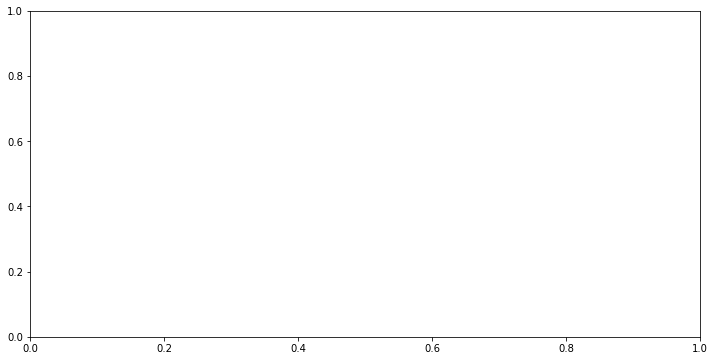

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model
import joblib
import matplotlib.pyplot as plt

# Step 1: Load the trained model and scaler
model = load_model('lstm_model.h5')
scaler = joblib.load('scaler.pkl')

# Step 2: Load the input and label data
input_data = pd.read_csv('Datasets/datasewithtime.csv')
labels = pd.read_csv('Datasets/resp.csv')

# Select relevant features
features = ['Speed1', 'SteeringWheelAngle1', 'Speed2', 'SteeringWheelAngle2']
input_data = input_data[features]

# Handle missing values
input_data.fillna(method='ffill', inplace=True)
input_data.fillna(input_data.mean(), inplace=True)

# Load actual Driver1_Responsibility
actual = labels['Driver1_Responsibility'].values

# Step 3: Create sequences
timesteps = 9
n_features = len(features)
n_sequences = len(labels)  # Should be 46

# Trim input data to exactly n_sequences * timesteps rows (46 * 9 = 414)
input_data = input_data.iloc[:n_sequences * timesteps]

# Normalize input data
input_data_scaled = scaler.transform(input_data)

# Create non-overlapping sequences
X = []
for i in range(0, len(input_data_scaled), timesteps):
    sequence = input_data_scaled[i:i + timesteps]
    if len(sequence) == timesteps:
        X.append(sequence)
X = np.array(X)

# Verify shape
print(f"Input sequences shape: {X.shape}")  # Should be (46, 9, 4)

# Step 4: Predict Driver1_Responsibility
predictions = model.predict(X, verbose=0)

# Rescale predictions from [0, 1] to [0, 100]
predictions_rescaled = predictions * 100

# Ensure predictions and actuals are aligned
if len(predictions_rescaled) != len(actual):
    print(f"Warning: Number of predictions ({len(predictions_rescaled)}) does not match number of actuals ({len(actual)})")
    min_len = min(len(predictions_rescaled), len(actual))
    predictions_rescaled = predictions_rescaled[:min_len]
    actual = actual[:min_len]

# Step 5: Compare predicted vs actual
comparison_df = pd.DataFrame({
    'Sequence': range(1, len(predictions_rescaled) + 1),
    'Predicted_Driver1_Responsibility (%)': predictions_rescaled.flatten(),
    'Actual_Driver1_Responsibility (%)': actual
})

# Round for display
comparison_df['Predicted_Driver1_Responsibility (%)'] = comparison_df['Predicted_Driver1_Responsibility (%)'].round(2)
comparison_df['Absolute_Error (%)'] = np.abs(comparison_df['Predicted_Driver1_Responsibility (%)'] - comparison_df['Actual_Driver1_Responsibility (%)']).round(2)

# Print comparison table
print("\nPredicted vs Actual Driver1_Responsibility:")
print(comparison_df.to_string(index=False))

# Step 6: Calculate error metrics
mae = mean_absolute_error(actual, predictions_rescaled)
mse = mean_squared_error(actual, predictions_rescaled)
rmse = np.sqrt(mse)

print(f"\nError Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}%")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}%")

# Step 7: Plot predicted vs actual
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Sequence'], comparison_df['Predicted_Driver1_Responsibility (%)'], marker='o', label='Predicted', color='blue')
plt.plot(comparison_df['Sequence'], comparison_df['Actual_Driver1_Responsibility (%)'], marker='x', label='Actual', color='red')
plt.title('Predicted vs Actual Driver1_Responsibility')
plt.xlabel('Sequence')
plt.ylabel('Driver1_Responsibility (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Save comparison to CSV
comparison_df.to_csv('prediction_comparison.csv', index=False)
print("\nComparison saved to 'prediction_comparison.csv'")

In [8]:
!pip install tensorflowjs


Defaulting to user installation because normal site-packages is not writeable


In [9]:
!tensorflowjs_converter --input_format=keras lstm_model.h5 tfjs_model/


/bin/bash: tensorflowjs_converter: command not found
